<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Stacked Charts**


Estimated time needed: **45** minutes


In this lab, you will focus on visualizing data specifically using stacked charts. You will use SQL queries to extract the necessary data and apply stacked charts to analyze the composition and comparison within the data.


## Objectives


In this lab, you will perform the following:


- Visualize the composition of data using stacked charts.

- Compare multiple variables across different categories using stacked charts.

- Analyze trends within stacked chart visualizations.


## Setup: Downloading and Loading the Data
**Install the libraries**


In [13]:
!pip install pandas
!pip install matplotlib

**Download and Load the Data**


To start, download and load the dataset into a `pandas` DataFrame.



### Step 1: Download the dataset


In [2]:
!wget -O survey-data.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/n01PQ9pSmiRX6520flujwQ/survey-data.csv

--2025-08-15 13:03:45--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/n01PQ9pSmiRX6520flujwQ/survey-data.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
200 OKequest sent, awaiting response... 
Length: 159525875 (152M) [text/csv]
Saving to: ‘survey-data.csv’

survey-data.csv     100%[===================>] 152.13M  68.8MB/s    in 2.2s    

2025-08-15 13:03:48 (68.8 MB/s) - ‘survey-data.csv’ saved [159525875/159525875]



### Step 2: Import necessary libraries and load the dataset


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

### Load the data


In [4]:
df = pd.read_csv("survey-data.csv")

# Create a connection to the SQLite database named 'survey.db'
# If the database file does not exist, it will be created automatically
conn = sqlite3.connect("survey.db")
#cursor = conn.cursor()

# Save the DataFrame into SQL table called 'survey'
df.to_sql('survey', conn, index=False, if_exists='replace')

# Check that table is created
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

# Close the connection
# conn.close()

     name
0  survey


### Display the first few rows of the data to understand its structure


In [5]:
df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


In [6]:
# Set max_rows to None to display all rows
pd.set_option('display.max_rows', None)
# Set the option to display all columns
pd.set_option('display.max_columns', None)
# ===================================================================================================
# Functional automatization & Data Preprocessing

def get_summary_stats(df):
    """
    Returns summary statistics for each column in the DataFrame.
    """
    return pd.DataFrame({
        "Column name": df.columns,  # Column names
        "DataType": df.dtypes.values,  # Data types of columns
        "Number of rows": df.shape[0],  # Total number of rows
        "Number of columns": df.shape[1],  # Total number of columns
        "Not-Null Columns": df.notnull().sum().values,  # Count of non-missing values
        "Missing Count": df.isnull().sum().values,  # Count of missing values
        "Missing Percentage": (df.isnull().mean() * 100).values  # Percentage of missing values
    })

summary_stats = get_summary_stats(df)
display(summary_stats)

# ===================================================================================================

# ===================================================================================================
def split_and_explode(df, column, sep=';'):
    """
    Split a column by a separator and explode it into multiple rows.
    Also strips leading/trailing spaces from each element.

    df: input DataFrame
    column: name of the column to split & explode
    sep: separator to split the string (default: ';')
    """
    df_copy = df.copy()
    # Split the column
    df_copy[column] = df_copy[column].str.split(sep)
    # Explode into multiple rows
    df_copy = df_copy.explode(column)
    # Remove leading/trailing spaces
    df_copy[column] = df_copy[column].str.strip()
    
    return df_copy
# ===================================================================================================

# ===================================================================================================
# Age mapping
age_mapping = {
    'Under 18 years old': 17,
    '18-24 years old': 21,
    '25-34 years old': 29.5,
    '35-44 years old': 39.5,
    '45-54 years old': 49.5,
    '55-64 years old': 59.5,
    '65 years or older': 70,
    'Prefer not to say': None
}

# YearsCodePro mapping
years_mapping = {
    'Less than 1 year': 0.5,
    'More than 50 years': 51
}

def prepare_dataframe(df, columns, remove_outliers=False, iqr_column=None):
    """
    Prepares a DataFrame for plotting or analysis.
    
    Parameters:
        df (DataFrame): Original DataFrame.
        columns (list): List of columns to keep (drop rows with NaN in these columns).
        remove_outliers (bool): Whether to remove extreme values using IQR.
        iqr_column (str): Column used for IQR calculation.
    
    Returns:
        DataFrame: Cleaned DataFrame ready for analysis.
    """
    df_clean = df.copy()
    
    # Map Age values to numerical values
    if 'Age' in df_clean.columns:
        df_clean['Age_mapped'] = df_clean['Age'].map(age_mapping)
    
    # Replace text-based YearsCodePro values and convert to numeric
    if 'YearsCodePro' in df_clean.columns:
        df_clean['YearsCodePro'] = df_clean['YearsCodePro'].replace(years_mapping)
        df_clean['YearsCodePro'] = pd.to_numeric(df_clean['YearsCodePro'], errors='coerce')
    
    # Drop NaN values in the required columns
    df_clean = df_clean.dropna(subset=columns).copy()
    
    # Remove outliers if enabled
    if remove_outliers and iqr_column:
        Q1 = df_clean[iqr_column].quantile(0.25)
        Q3 = df_clean[iqr_column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[iqr_column] >= lower) & (df_clean[iqr_column] <= upper)].copy()
    
    return df_clean
# ===================================================================================================

,Column name,DataType,Number of rows,Number of columns,Not-Null Columns,Missing Count,Missing Percentage
0,ResponseId,int64,65437,114,65437,0,0.000000
1,MainBranch,object,65437,114,65437,0,0.000000
2,Age,object,65437,114,65437,0,0.000000
3,Employment,object,65437,114,65437,0,0.000000
4,RemoteWork,object,65437,114,54806,10631,16.246160
5,Check,object,65437,114,65437,0,0.000000
6,CodingActivities,object,65437,114,54466,10971,16.765744
7,EdLevel,object,65437,114,60784,4653,7.110656
8,LearnCode,object,65437,114,60488,4949,7.563000
9,LearnCodeOnline,object,65437,114,49237,16200,24.756636


### Task 1: Stacked Chart for Composition of Job Satisfaction Across Age Groups


##### 1. Stacked Chart of Median `JobSatPoints_6` and `JobSatPoints_7` for Different Age Groups


Visualize the composition of job satisfaction scores (`JobSatPoints_6` and `JobSatPoints_7`) across various age groups. This will help in understanding the breakdown of satisfaction levels across different demographics.



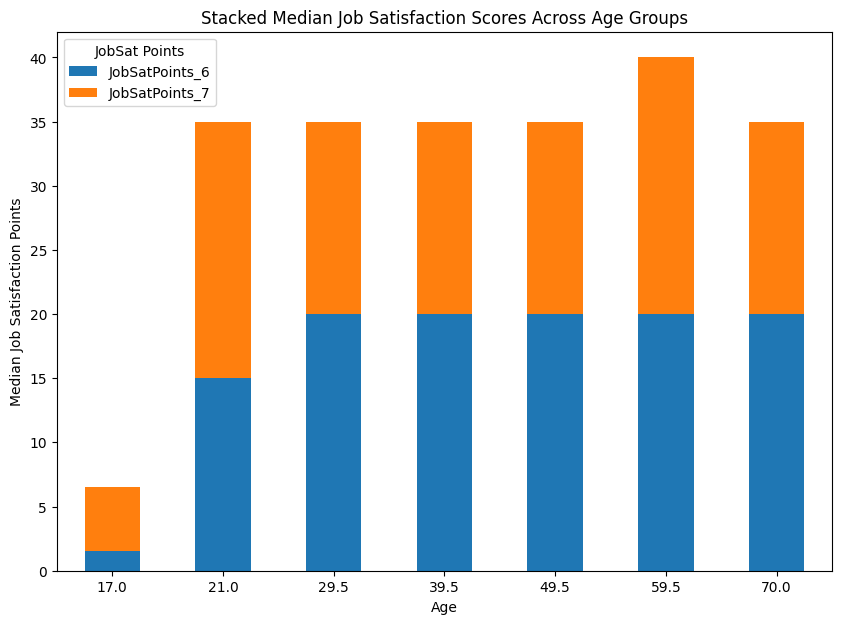

In [40]:
##Write your code here

# Load only the necessary columns
query = """
select Age, JobSatPoints_6, JobSatPoints_7
from survey
"""

df_task1 = pd.read_sql_query(query, conn)

# Map age and drop rows with NaN in Age or JobSatPoints
df_clean = prepare_dataframe(df_task1, columns=['Age', 'JobSatPoints_6', 'JobSatPoints_7'])

# Group by Age_mapped and calculate median of JobSatPoints_6 and JobSatPoints_7
median_scores = df_clean.groupby('Age_mapped')[['JobSatPoints_6', 'JobSatPoints_7']].median()

# Plot stacked bar chart
median_scores.plot(kind='bar', stacked=True, figsize=(10,7), color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Age')
plt.ylabel('Median Job Satisfaction Points')
plt.title('Stacked Median Job Satisfaction Scores Across Age Groups')
plt.legend(title='JobSat Points')
plt.xticks(rotation=0)
plt.show()

##### Stacked Chart of `JobSatPoints_6` and `JobSatPoints_7` for Employment Status


Create a stacked chart to compare job satisfaction (`JobSatPoints_6` and `JobSatPoints_7`) across different employment statuses. This will show how satisfaction varies by employment type.


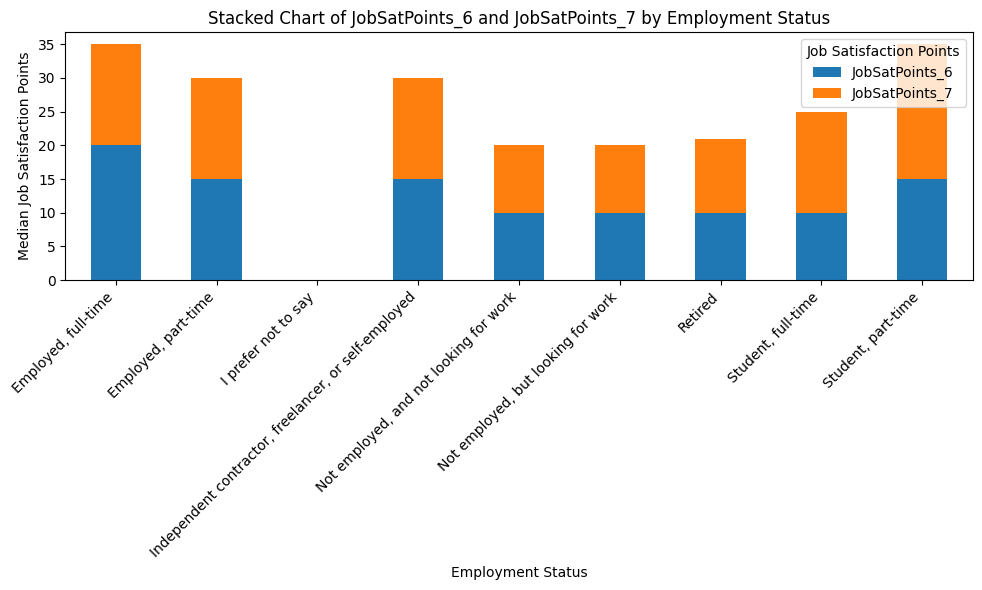

In [41]:
##Write your code here
# df['Employment'].isnull().sum()

# Load data for the task into a separate DataFrame
query = """
SELECT Employment, JobSatPoints_6, JobSatPoints_7
FROM survey
"""
df_task2 = pd.read_sql_query(query, conn)

# Use your automated split_and_explode function
df_exploded = split_and_explode(df_task2, 'Employment', sep=';')

# Group by Employment and calculate median for JobSatPoints_6 and JobSatPoints_7
median_df = df_exploded.groupby('Employment')[['JobSatPoints_6', 'JobSatPoints_7']].median()

# Plot stacked bar chart
median_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked Chart of JobSatPoints_6 and JobSatPoints_7 by Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Median Job Satisfaction Points')
plt.legend(title='Job Satisfaction Points')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Task 2: Stacked Chart for Compensation and Job Satisfaction by Age Group


##### This stacked chart visualizes the composition of compensation (`ConvertedCompYearly`) and job satisfaction (`JobSatPoints_6`) specifically for respondents aged 30-35.


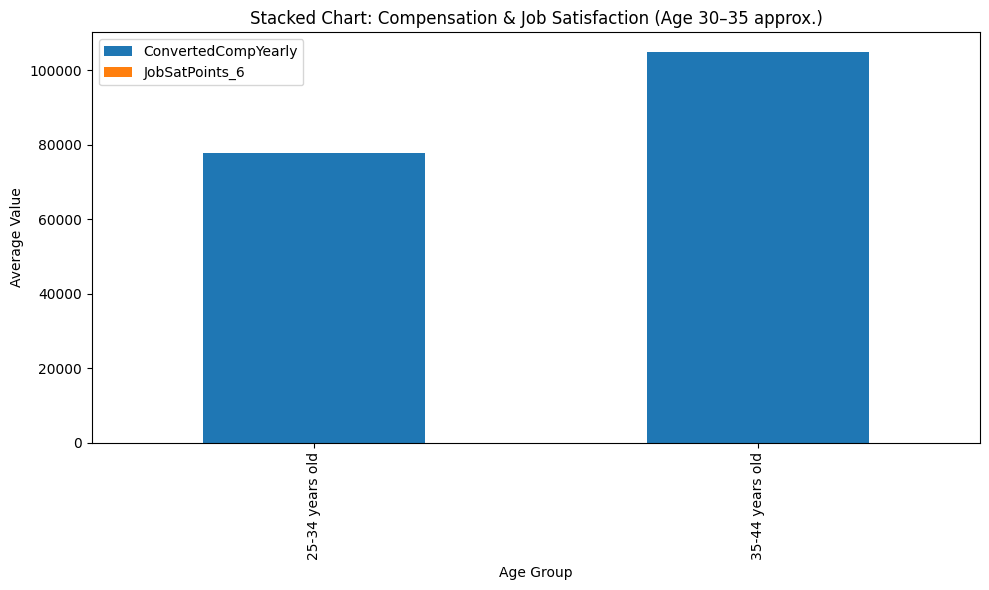

In [54]:
##Write your code here
# Read necessary columns from table
query = """
SELECT Age, ConvertedCompYearly, JobSatPoints_6
FROM survey
"""
task3_df = pd.read_sql_query(query, conn)

# Age mapping dictionary
age_mapping = {
    'Under 18 years old': 17,
    '18-24 years old': 21,
    '25-34 years old': 29.5,
    '35-44 years old': 39.5,
    '45-54 years old': 49.5,
    '55-64 years old': 59.5,
    '65 years or older': 70,
    'Prefer not to say': None
}

# Apply mapping
task3_df["Age_mapped"] = task3_df["Age"].map(age_mapping)

# Keep only rows where original Age is '25-34 years old' or '35-44 years old'
# so we capture the 30–35 range approximately
df_filtered = task3_df[task3_df["Age"].isin(["25-34 years old", "35-44 years old"])]

# Drop rows where compensation or job satisfaction is missing
df_filtered = df_filtered.dropna(subset=["ConvertedCompYearly", "JobSatPoints_6"])

# Calculate average values for each Age group
df_grouped = df_filtered.groupby("Age")[
    ["ConvertedCompYearly", "JobSatPoints_6"]
].mean()

# Plot stacked bar chart
df_grouped.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Stacked Chart: Compensation & Job Satisfaction (Age 30–35 approx.)")
plt.ylabel("Average Value")
plt.xlabel("Age Group")
plt.legend(["ConvertedCompYearly", "JobSatPoints_6"])
plt.tight_layout()
plt.show()


# I didn’t filter by Age_mapped 30–35, because with the given mapping, there are no exact 30, 31, etc..

# Instead, I included 25–34 and 35–44 to approximate the 30–35 range.

##### Stacked Chart of Median Compensation and Job Satisfaction Across Age Group


Compare the median compensation and job satisfaction metrics across different age groups. This helps visualize how compensation and satisfaction levels differ by age.


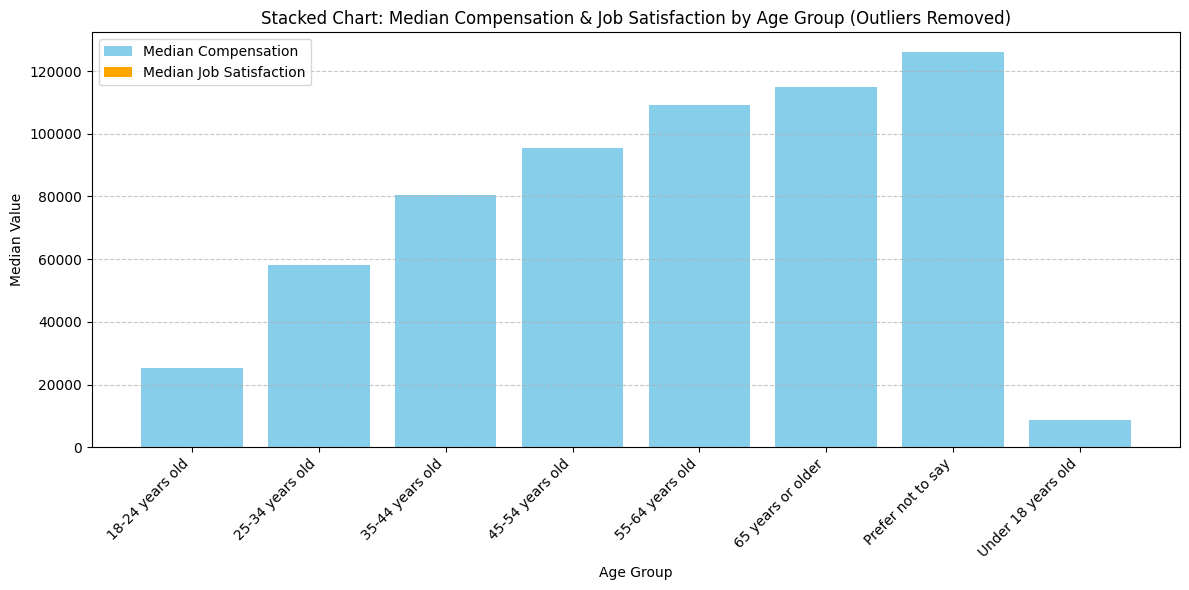

In [68]:
##Write your code here
# df['Age'].unique()

query = """
SELECT Age, ConvertedCompYearly, JobSatPoints_6
FROM survey
"""
df = pd.read_sql_query(query, conn)

age_mapping = {
    "Under 18 years old": 17,
    "18-24 years old": 21,
    "25-34 years old": 30,
    "35-44 years old": 40,
    "45-54 years old": 50,
    "55-64 years old": 60,
    "65 years or older": 70,
    "Prefer not to say": None
}

def prepare_dataframe(df, columns, remove_outliers=False, iqr_column=None):
    df_clean = df.copy()
    
    # Map Age values to numerical
    if 'Age' in df_clean.columns:
        df_clean['Age_mapped'] = df_clean['Age'].map(age_mapping)
    
    df_clean = df_clean.dropna(subset=columns).copy()
    
    if remove_outliers and iqr_column:
        Q1 = df_clean[iqr_column].quantile(0.25)
        Q3 = df_clean[iqr_column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[iqr_column] >= lower) & (df_clean[iqr_column] <= upper)].copy()
    
    return df_clean

df_clean = prepare_dataframe(
    df,
    columns=["ConvertedCompYearly", "JobSatPoints_6"],
    remove_outliers=True,
    iqr_column="ConvertedCompYearly"
)

df_grouped = df_clean.groupby("Age")[
    ["ConvertedCompYearly", "JobSatPoints_6"]
].median()

plt.figure(figsize=(12, 6))
plt.bar(df_grouped.index, df_grouped["ConvertedCompYearly"], label="Median Compensation", color="skyblue")
plt.bar(df_grouped.index, df_grouped["JobSatPoints_6"], 
        bottom=df_grouped["ConvertedCompYearly"], label="Median Job Satisfaction", color="orange")

plt.xlabel("Age Group")
plt.ylabel("Median Value")
plt.title("Stacked Chart: Median Compensation & Job Satisfaction by Age Group (Outliers Removed)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Task 3: Comparing Data Using Stacked Charts


##### 1. Stacked Chart of Preferred Databases by Age Group




Visualize the top databases that respondents from different age groups wish to learn. Create a stacked chart to show the proportion of each database in each age group.


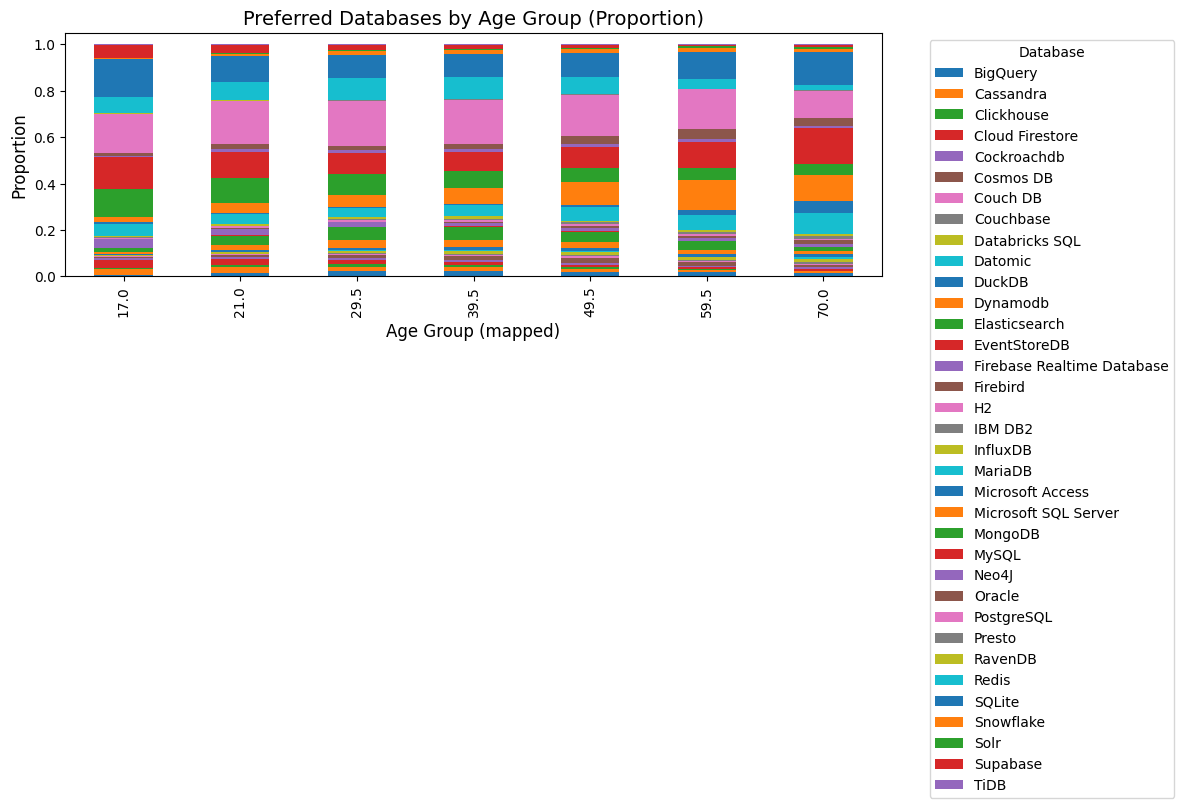

In [7]:
##Write your code here
# Connect to the database
conn = sqlite3.connect('survey.db')

# Read data
task1_df = pd.read_sql("SELECT Age, DatabaseWantToWorkWith FROM survey", conn)

# Close connection
conn.close()

# Prepare dataframe
task1_df = prepare_dataframe(task1_df, columns=['Age', 'DatabaseWantToWorkWith'])
task1_df = split_and_explode(task1_df, 'DatabaseWantToWorkWith')

# Group by Age and Database
grouped = task1_df.groupby(['Age_mapped', 'DatabaseWantToWorkWith']).size().reset_index(name='Count')

# Pivot for stacked chart
pivot_df = grouped.pivot(index='Age_mapped', columns='DatabaseWantToWorkWith', values='Count').fillna(0)

# Normalize to proportions
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Plot stacked chart
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))

# Labels and title
plt.title('Preferred Databases by Age Group (Proportion)', fontsize=14)
plt.xlabel('Age Group (mapped)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Database', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### 2. Stacked Chart of Employment Type by Job Satisfaction


Analyze the distribution of employment types within each job satisfaction level using a stacked chart. This will provide insights into how employment types are distributed across various satisfaction ratings.


/tmp/ipykernel_301/3211004323.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


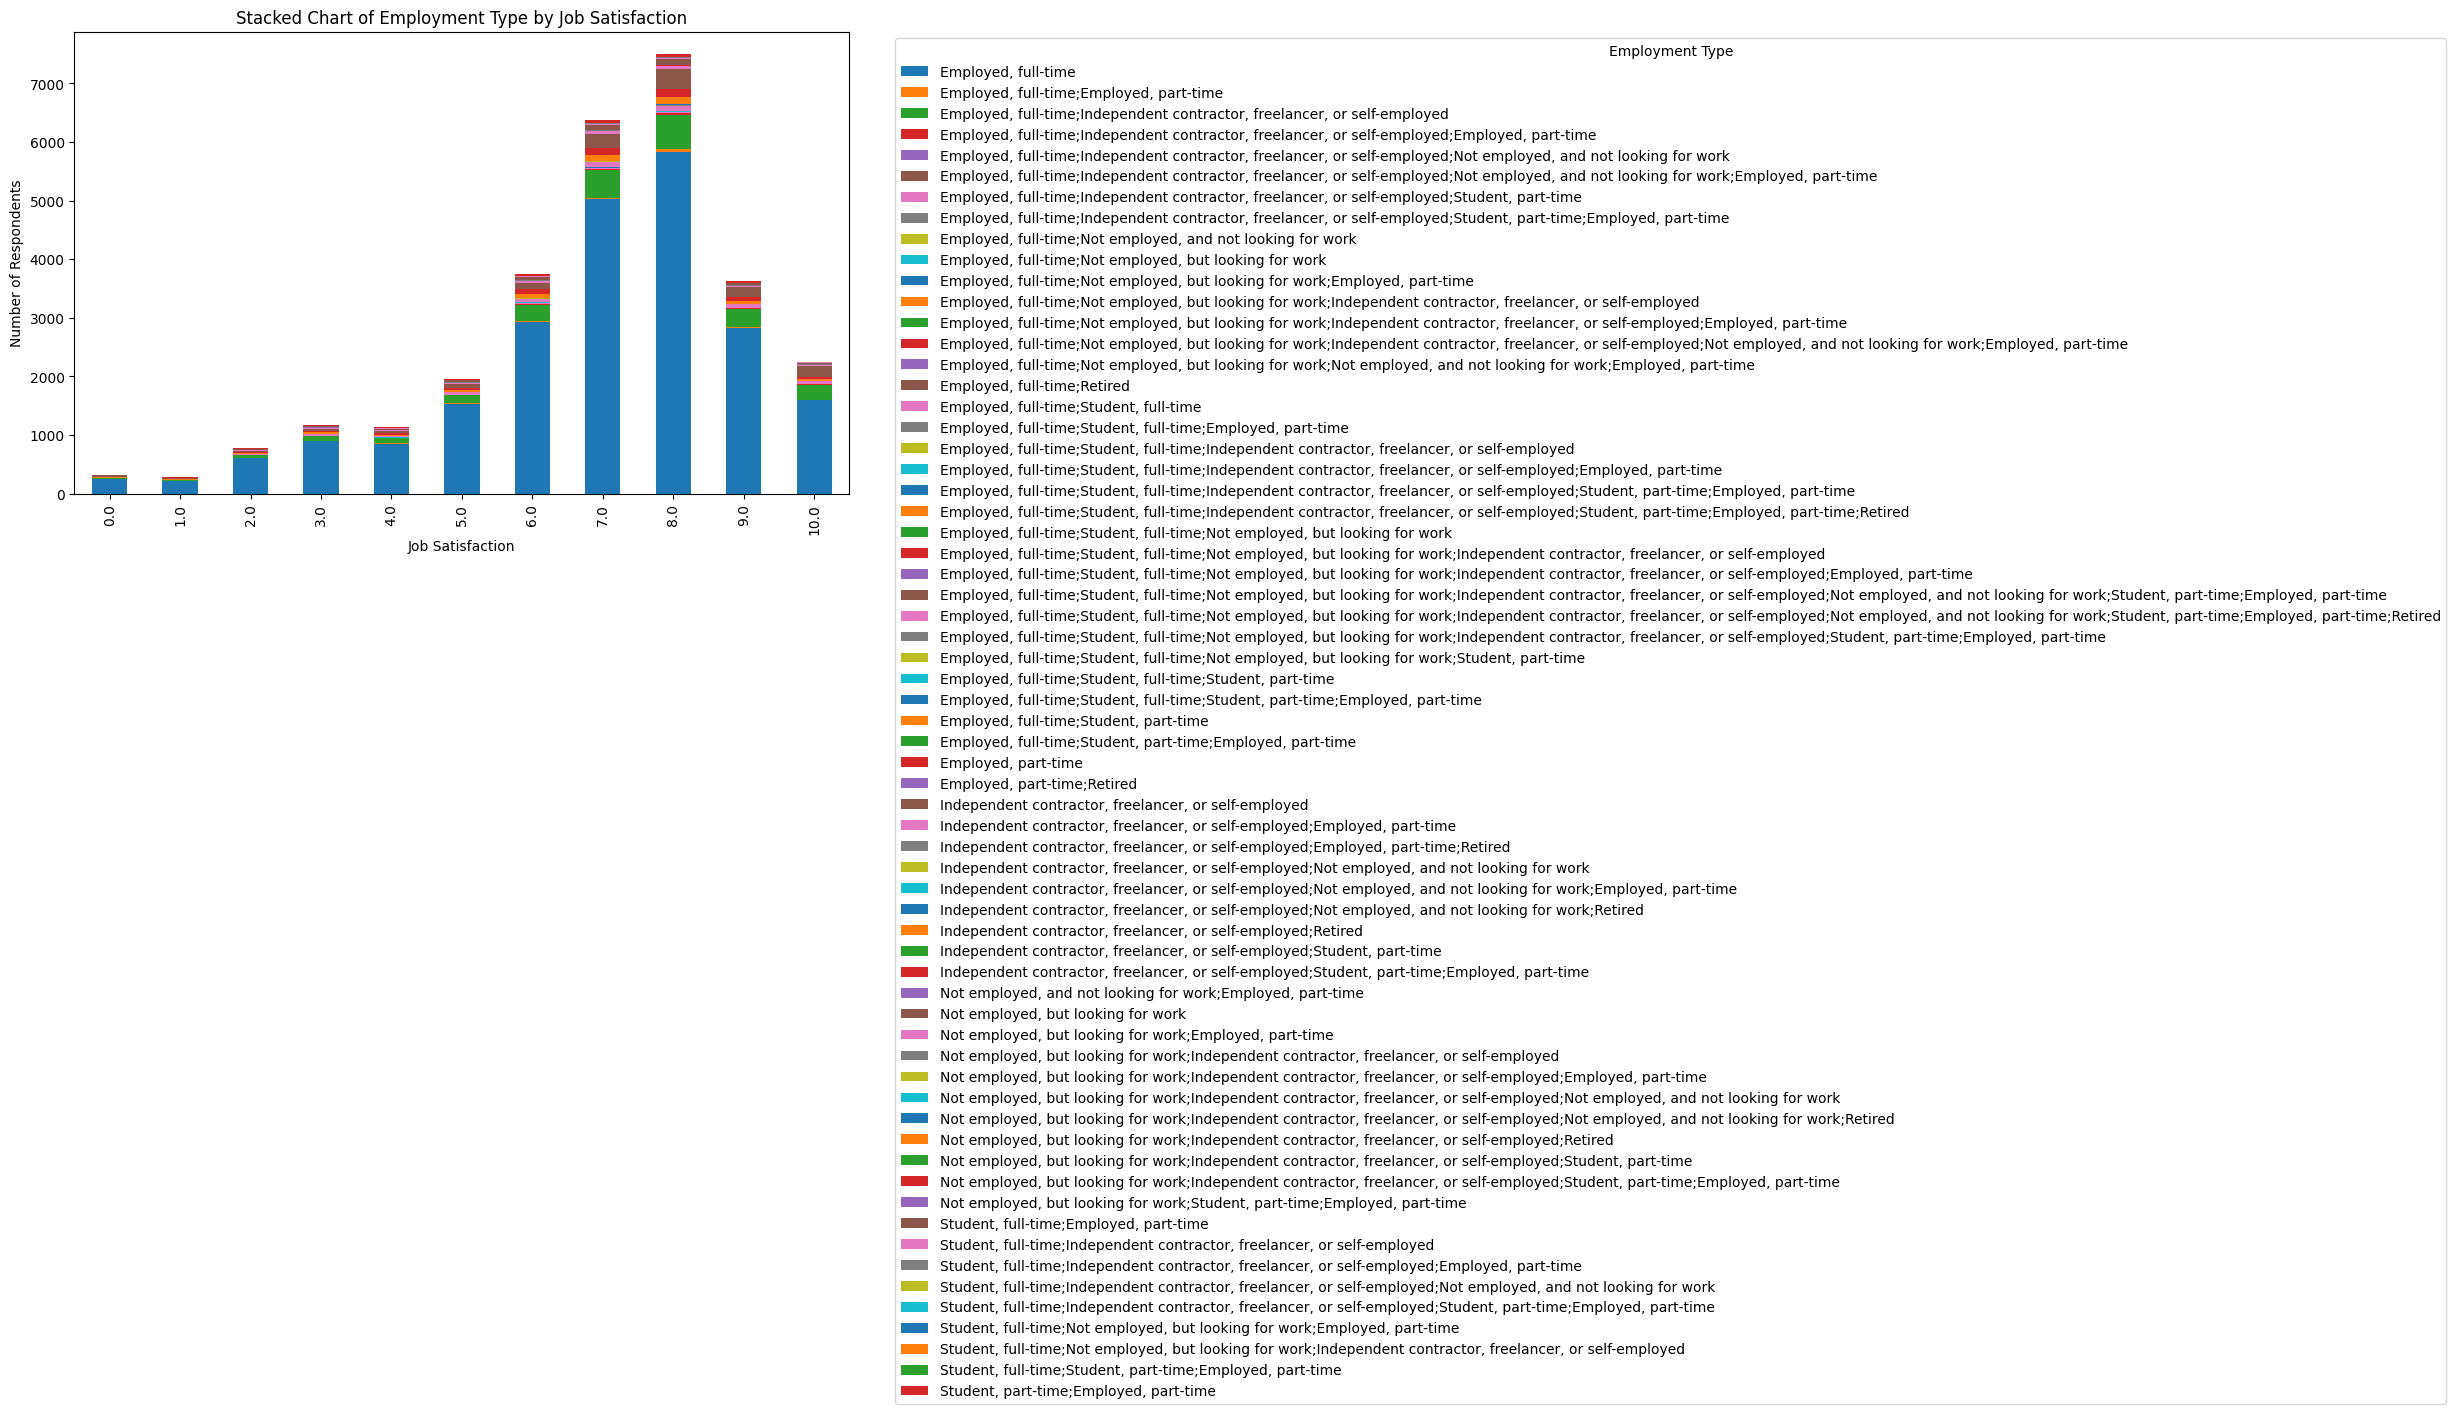

In [8]:
##Write your code here
# Connect to SQLite database
conn = sqlite3.connect("survey.db")

# Load necessary columns from the table 'survey'
query = """
SELECT Employment, JobSat
FROM survey
WHERE Employment IS NOT NULL
  AND JobSat IS NOT NULL
"""
task_df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Create a crosstab of Job Satisfaction vs Employment Type
# Rows: JobSat, Columns: Employment
crosstab_df = pd.crosstab(task_df['JobSat'], task_df['Employment'])

# Plot stacked bar chart
crosstab_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title("Stacked Chart of Employment Type by Job Satisfaction")
plt.xlabel("Job Satisfaction")
plt.ylabel("Number of Respondents")
plt.legend(title="Employment Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

### Task 4: Exploring Technology Preferences Using Stacked Charts


##### 1. Stacked Chart for Preferred Programming Languages by Age Group


Analyze how programming language preferences (`LanguageAdmired`) vary across age groups.


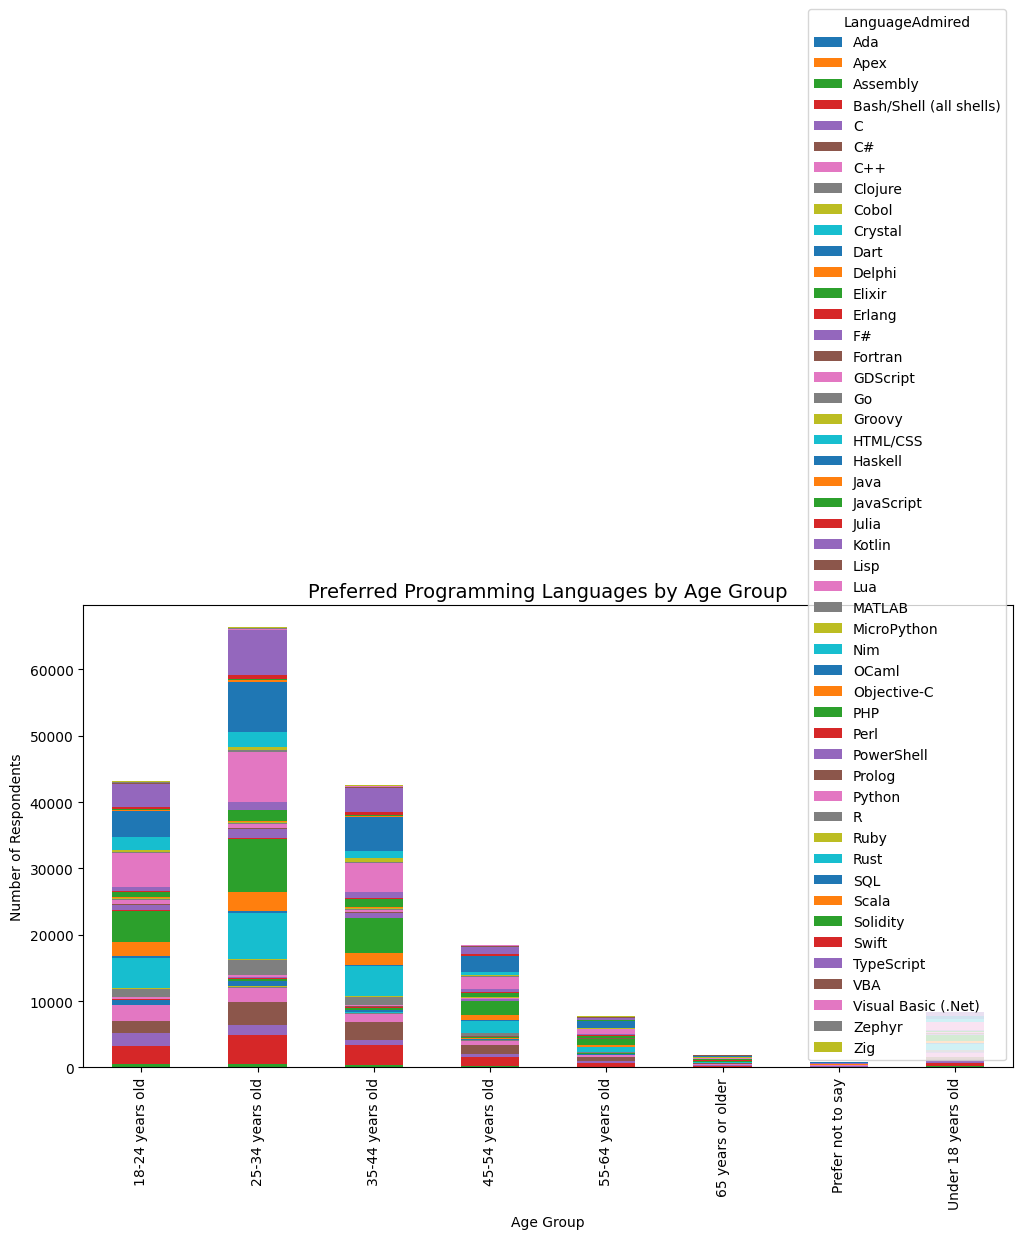

In [9]:
##Write your code here
# df['LanguageAdmired'].unique()

# Create a copy of the original dataframe for this task
task_lang_df = df.copy()

# Expand multiple languages in "LanguageAdmired" into separate rows
task_lang_df = task_lang_df.assign(LanguageAdmired=task_lang_df['LanguageAdmired'].str.split(';')).explode('LanguageAdmired')

# Drop rows where either Age or LanguageAdmired is missing
task_lang_df = task_lang_df.dropna(subset=['Age', 'LanguageAdmired'])

# Group by Age and LanguageAdmired, then count occurrences
lang_age_group = task_lang_df.groupby(['Age', 'LanguageAdmired']).size().reset_index(name='Count')

# Pivot the table to prepare for stacked bar chart
lang_age_pivot = lang_age_group.pivot(index='Age', columns='LanguageAdmired', values='Count').fillna(0)

# Plot stacked bar chart
lang_age_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add chart title and labels
plt.title('Preferred Programming Languages by Age Group', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Number of Respondents')

# Show the plot
plt.show()

##### 2. Stacked Chart for Technology Adoption by Employment Type


Explore how admired platforms (`PlatformAdmired`) differ across employment types (e.g., full-time, freelance)


/tmp/ipykernel_301/2106128328.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


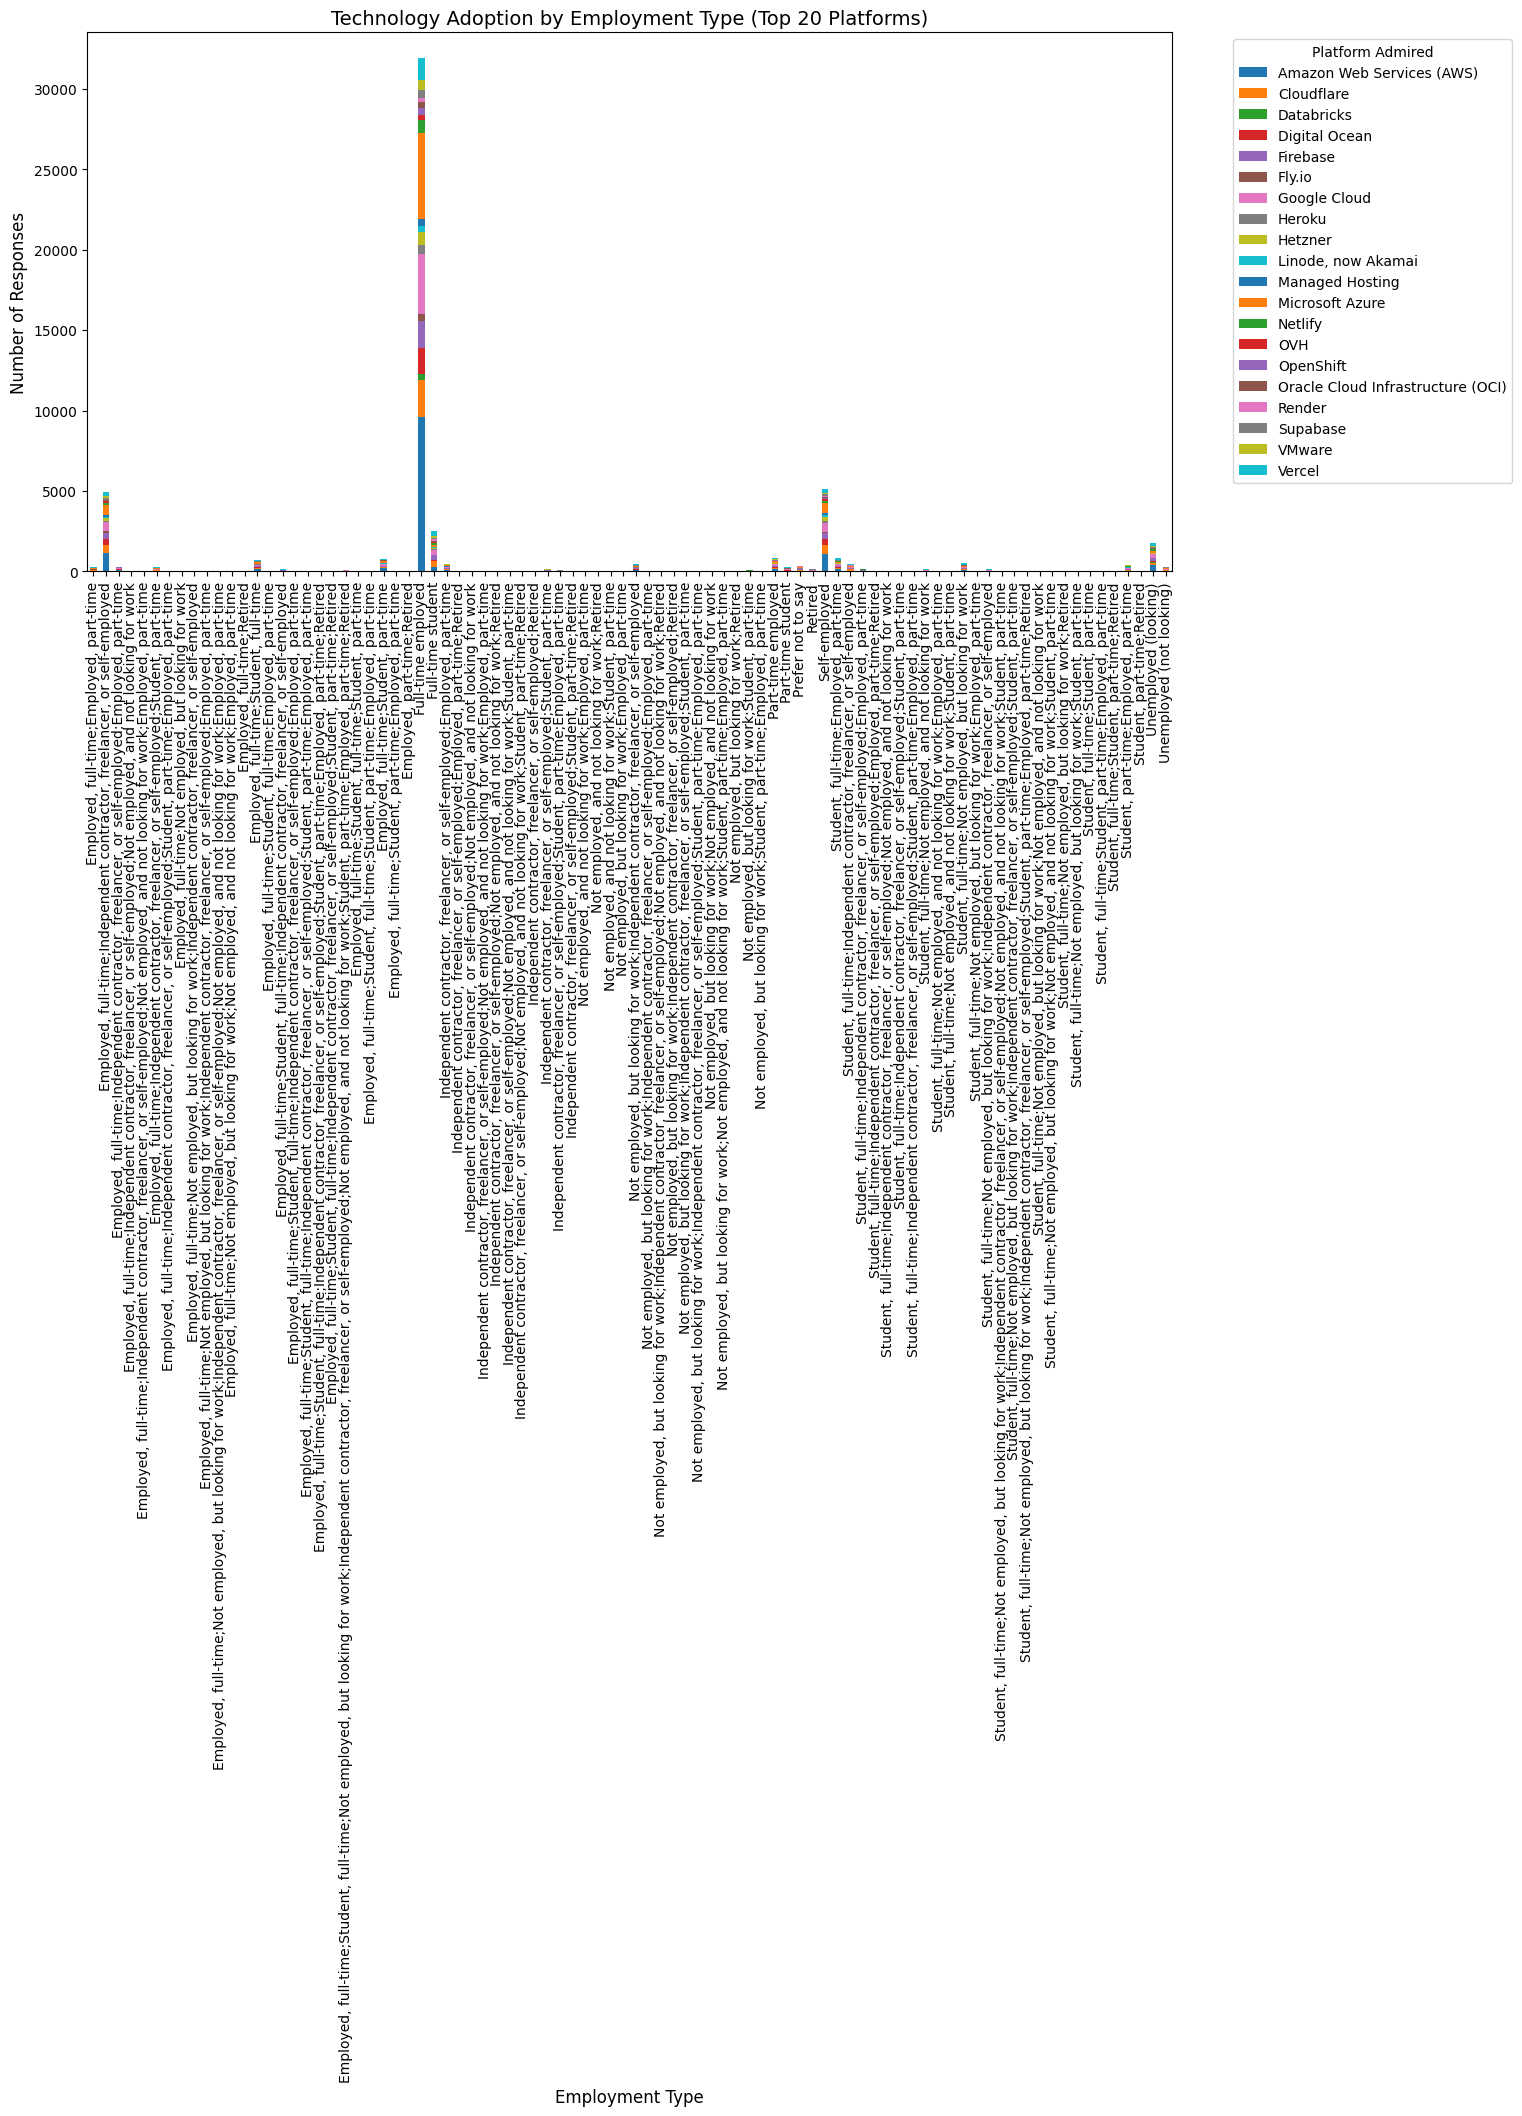

In [ ]:
##Write your code here
conn = sqlite3.connect("survey.db")

query = """
SELECT Employment, PlatformAdmired
FROM survey
WHERE Employment IS NOT NULL
  AND PlatformAdmired IS NOT NULL;
"""
df_task = pd.read_sql_query(query, conn)

# Маппинг Employment
employment_mapping = {
    'Employed, full-time': 'Full-time employed',
    'Employed, part-time': 'Part-time employed',
    'Independent contractor, freelancer, or self-employed': 'Self-employed',
    'Student, full-time': 'Full-time student',
    'Student, part-time': 'Part-time student',
    'Not employed, but looking for work': 'Unemployed (looking)',
    'Not employed, and not looking for work': 'Unemployed (not looking)',
    'Retired': 'Retired',
    'I prefer not to say': 'Prefer not to say'
}

df_task['Employment'] = df_task['Employment'].map(employment_mapping).fillna(df_task['Employment'])

def split_and_explode(df, column, sep=';'):
    df_copy = df.copy()
    df_copy[column] = df_copy[column].str.split(sep)
    df_copy = df_copy.explode(column)
    df_copy[column] = df_copy[column].str.strip()
    return df_copy

df_task = split_and_explode(df_task, 'PlatformAdmired')

top_platforms = df_task['PlatformAdmired'].value_counts().head(20).index
df_task = df_task[df_task['PlatformAdmired'].isin(top_platforms)]

grouped = df_task.groupby(['Employment', 'PlatformAdmired']).size().reset_index(name='Count')

pivot_df = grouped.pivot(index='Employment', columns='PlatformAdmired', values='Count').fillna(0)

pivot_df.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title("Technology Adoption by Employment Type (Top 20 Platforms)", fontsize=14)
plt.xlabel("Employment Type", fontsize=12)
plt.ylabel("Number of Responses", fontsize=12)
plt.legend(title="Platform Admired", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
df['Employment'].unique()

array(['Employed, full-time', 'Student, full-time',
       'Student, full-time;Not employed, but looking for work',
       'Independent contractor, freelancer, or self-employed',
       'Not employed, and not looking for work',
       'Employed, full-time;Student, part-time',
       'Employed, full-time;Independent contractor, freelancer, or self-employed',
       'Employed, full-time;Student, full-time', 'Employed, part-time',
       'Student, full-time;Employed, part-time',
       'Student, part-time;Employed, part-time', 'I prefer not to say',
       'Not employed, but looking for work', 'Student, part-time',
       'Employed, full-time;Student, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time',
       'Employed, full-time;Independent contractor, freelancer, or self-employed;Student, part-time',
       'Independent contractor, freelancer, or self-employed;Employed, part-time',
       'Independent contractor, freelancer, or self-employed;Student, par

### Final Step: Review


In this lab, you focused on using stacked charts to understand the composition and comparison within the dataset. Stacked charts provided insights into job satisfaction, compensation, and preferred databases across age groups and employment types.


## Summary


After completing this lab, you will be able to:

- Use stacked charts to analyze the composition of data across categories, such as job satisfaction and compensation by age group.

- Compare data across different dimensions using stacked charts, enhancing your ability to communicate complex relationships in the data.

- Visualize distributions across multiple categories, such as employment type by satisfaction, to gain a deeper understanding of patterns within the dataset.


## Author:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


<!--
## Change Log
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2024-10-28|1.2|Madhusudhan Moole|Updated lab|
|2024-10-16|1.1|Madhusudhan Moole|Updated lab|
|2024-10-15|1.0|Raghul Ramesh|Created lab|
--!>


Copyright © IBM Corporation. All rights reserved.
